<a href="https://colab.research.google.com/github/meonaddis/Streamlit_Abyssinia/blob/master/Dynamic_World.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Copyright 2022 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Overview

This notebook provides an introduction to the `Dynamic World` near realtime land cover dataset.

The content in this notebook has been adapted from several sources, described in the [Additional Resources](#resources) section.

# Setup

## Authentication

Authenticate and authorize access to Earth Engine.

In [ ]:
COLAB_AUTH_FLOW_CLOUD_PROJECT_FOR_API_CALLS = 'MY_CLOUD_PROJECT_ID'

import ee
import google
import os

if COLAB_AUTH_FLOW_CLOUD_PROJECT_FOR_API_CALLS is None:
  print("Authenticating using Notebook auth...")
  if os.path.exists(ee.oauth.get_credentials_path()) is False:
    ee.Authenticate()
  else:
    print('\N{check mark} '
          'Previously created authentication credentials were found.')
  ee.Initialize()
else:
  print('Authenticating using Colab auth...')
  # Authenticate to populate Application Default Credentials in the Colab VM.
  google.colab.auth.authenticate_user()
  # Create credentials needed for accessing Earth Engine.
  credentials, auth_project_id = google.auth.default()
  # Initialize Earth Engine.
  ee.Initialize(credentials, project=COLAB_AUTH_FLOW_CLOUD_PROJECT_FOR_API_CALLS)
print('\N{check mark} Successfully initialized!')

Authenticating using Colab auth...
✓ Successfully initialized!


## Install & import Python packages

### About the earthengine_jupyter package

This notebook uses the [earthengine-jupyter](https://github.com/google/earthengine-jupyter) Python package, which provides helpful tools for working with Earth Engine from within a [Jupyter](https://jupyter.org/) environment. It currently enables use of interactive map and inspector widgets.

⚠️ Note that as of December 2022, the package is **experimental** and is **not ready for production use**.


In [ ]:
try:
  import ee_jupyter
except ModuleNotFoundError:
  print('ee_jupyter was not found. Installing now...')
  result = os.system('pip -q install earthengine-jupyter')
  import ee_jupyter
print(f'ee_jupyter (version {ee_jupyter.__version__}) '
        f'is installed.')

ee_jupyter was not found. Installing now...
ee_jupyter (version 0.0.7) is installed.


Import other Python packages used throughout this notebook.

In [ ]:
import altair as alt
from ee_jupyter.ipyleaflet import Map
from ee_jupyter.ipyleaflet import Inspector
from ee_jupyter.layout import MapWithInspector
import ipyleaflet
import ipywidgets as widgets
from IPython.display import display
from IPython.display import HTML
from IPython.display import IFrame
from IPython.display import Image
import pandas as pd
from pprint import pprint  # for pretty printing
import pydot

Enable custom widgets in Colab.

In [ ]:
from google.colab import output
output.enable_custom_widget_manager()

# Introduction to Dynamic World

This section provides a high level overview of the Dynamic World Dataset. The dataset contains near real-time (NRT) land use land cover (LULC) predictions created from Sentinel-2 imagery for nine land use land cover (LULC) classes as described in the table below.

| LULC Type	         | Description |
| ------------------ | ----------- |
| Water	             | Permanent and seasonal water bodies |
| Trees              | 	Includes primary and secondary forests, as well as large-scale plantations |
| Grass	             | Natural grasslands, livestock pastures, and parks |
| Flooded vegetation | Mangroves and other inundated ecosystems |
| Crops	             | Include row crops and paddy crops |
| Shrub & Scrub	     | Sparse to dense open vegetation consisting of shrubs |
| Built Area         | Low- and high-density buildings, roads, and urban open space |
| Bare ground	       | Deserts and exposed rock |
| Snow & Ice         | Permanent and seasonal snow cover |

This tutorial provides examples of how to use Earth Engine to load and visualize this rich 10m resolution probability-per-pixel land use land cover dataset. The tutorial also covers techniques to compute statistics and analyze the probability time-series data for change detection.

In [ ]:
#@title Dynamic World Website (https://dynamicworld.app)
IFrame('https://dynamicworld.app/', width=1000, height=500)

To make it easy to explore the Dynamic World dataset without needed to code, we have created an Earth Engine App. You can experiment with the app from within this notebook by running the code cell below, or open it up as a separate webpage using this link: https://earthoutreach.users.earthengine.app/view/dynamicworld

In [ ]:
#@title Dynamic World app
IFrame('https://earthoutreach.users.earthengine.app/view/dynamicworld', width=1000, height=800)

This tutorial is primarily focused on accessing and analyzing the Dynamic World dataset using the Earth Engine Python client library. For examples using the Code Editor, see the [Additional Resources](#additional-resources) section.

# Part 1 - Visualization and Creating Composites

## Hello [Dynamic] World

The Dynamic World (DW) dataset is a continuously updating Image Collection of globally consistent, 10m-resolution, near real-time (NRT) land use land cover (LULC) predictions created from Sentinel-2 imagery. Images in this dataset include ten bands: nine bands with estimated probabilities for each of the nine DW LULC classes as well as a class "label" band indicating the class with the largest estimated probability. These unique properties enable users to do multi-temporal analysis as well as create custom products suited to their needs.

### Using the NRT Image Collection

The Dynamic World Near Real-time (NRT) Image Collection includes LULC predictions for Sentinel-2 L1C acquisitions from 2015-06-23 to the present where the CLOUDY_PIXEL_PERCENTAGE metadata is less than 35%. The Image Collection is continuously updated in near real-time with predictions generated for new [Sentinel-2 L1C harmonized](https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_HARMONIZED) images as they become available in Google Earth Engine.

The [Dynamic World NRT collection](https://developers.google.com/earth-engine/datasets/catalog/GOOGLE_DYNAMICWORLD_V1) is available at `GOOGLE/DYNAMICWORLD/V1`. The images in this collection have names that match the individual Sentinel-2 L1C product names from which they were derived.

Let's see how we can find and load the Dynamic World classification for a specific Sentinel-2 image.

We first define the variables containing the start date, end date, and coordinates of a location. Here we have defined a point centered at the Quabbin Reservoir in Massachusetts, US.

In [ ]:
example = {
    'start_date': '2021-10-15',
    'end_date': '2021-10-25',
    'latitude': 42.36103,
    'longitude': -72.28525,
    'zoom': 10
}

And use those parameters to create a map

In [ ]:
map_init_params_ma = {
    'center': [example['latitude'], example['longitude']], # <lat,lon> ordering
    'zoom': 10,
    # 'layout': widgets.Layout(height='500px')
}
map1 = Map(**map_init_params_ma)
map1    # Display the map

Map(center=[42.36103, -72.28525], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', …

Note that the `<lat,lon>` coordinate ordering convention used for the interactive map, which is due to the underlying [leaflet mapping library](https://leafletjs.com/reference.html#latlng). By contrast, Earth Engine objects use the `<lon,lat>` or `<x,y>` coordinate ordering convention used by [GeoJSON spec](https://www.rfc-editor.org/rfc/rfc7946#section-3.1.1). For our example location, here is a corresponding Earth Engine Point geometry object:

In [ ]:
geometry = ee.Geometry.Point([example['longitude'], example['latitude']])

### Load a Sentinel-2 Image

We can find a Sentinel-2 image by applying filters on the Sentinel-2 L1C harmonized collection for the date range and location of interest. Since the Dynamic World classification is available only for scenes with < 35% cloud cover, we also apply a metadata filter.

In [ ]:
s2 = (ee.ImageCollection('COPERNICUS/S2_HARMONIZED')
        .filterDate(example['start_date'], example['end_date'])
        .filterBounds(geometry)
        .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 35))
)

The resulting collection in the `s2` variable contains all images matching the filters. Let's see how many images are available, given those filters.

In [ ]:
print(f'# of images = {s2.size().getInfo()}')

# of images = 6


We can call `.first()` to extract a single image (the earliest one matching our criteria) from the collection.

In [ ]:
s2_image = ee.Image(s2.first())

Once we have the image, let's add it to the map to visualize it. The code also centers the viewport at the coordinates of the point location.

In [ ]:
s2_vis_params = {'bands':['B4', 'B3', 'B2'], 'min':0, 'max':3000}
map1.addLayer(s2_image, s2_vis_params, 'Sentinel-2 Image')

If you scroll back up in the notebook to view, you can see it was added to the previously displayed map. But we can display a second copy of the map here:

In [ ]:
# A Sentinel-2 L1C Image of Quabbin Reservoir, Massachusetts, US
map1

Map(center=[42.36103, -72.28525], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', …

### Find the Matching Dynamic World Image

To find the matching classified image in the Dynamic World collection, we need to extract the scene id from the Sentinel-2 image using the `system:index` property.

In [ ]:
image_id = s2_image.get('system:index')
print(f'image_id = {image_id.getInfo()}')

image_id = 20211019T154251_20211019T154735_T18TYM


We can use the same id to load the matching Dynamic World scene. The code snippet below applies a filter on the Dynamic World collection and extracts the matching scene.

In [ ]:
dw_base = ee.ImageCollection('GOOGLE/DYNAMICWORLD/V1')
dw_filtered = dw_base.filter(ee.Filter.eq('system:index', image_id))
dw_image = ee.Image(dw_filtered.first())

### Visualize the Classified Image

The `label` band of Dynamic World images contains a discrete label for each pixel assigned based on the class with the highest probability. The nine-class taxonomy is described in the table below.

In [ ]:
# Label	LULC Type	Color	Description
dw_classes = {
    '0':{'LULC Type': 'Water',
         'band name': 'water',
         'color': '#419BDF',
         'description': 'Permanent and seasonal water bodies'},
    '1':{'LULC Type': 'Trees',
         'band name': 'trees',
         'color': '#397D49',
         'description': 'Includes primary and secondary forests, as well as large-scale plantations'},
    '2':{'LULC Type': 'Grass',
         'band name': 'grass',
         'color': '#88B053',
         'description': 'Natural grasslands, livestock pastures, and parks'},
    '3':{'LULC Type': 'Flooded vegetation',
         'band name': 'flooded_vegetation',
         'color': '#7A87C6',
         'description': 'Mangroves and other inundated ecosystems'},
    '4':{'LULC Type': 'Crops',
         'band name': 'crops',
         'color': '#E49635',
         'description': 'Include row crops and paddy crops'},
    '5':{'LULC Type': 'Shrub & Scrub',
         'band name': 'shrub_and_scrub',
         'color': '#DFC35A',
         'description': 'Sparse to dense open vegetation consisting of shrubs'},
    '6':{'LULC Type': 'Built Area',
         'band name': 'built',
         'color': '#C4281B',
         'description': 'Low- and high-density buildings, roads, and urban open space'},
    '7':{'LULC Type': 'Bare ground',
         'band name': 'bare',
         'color': '#A59B8F',
         'description': 'Deserts and exposed rock'},
    '8':{'LULC Type': 'Snow & Ice',
         'band name': 'snow_and_ice',
         'color': '#B39FE1',
         'description': 'Permanent and seasonal snow cover'},
}

In [ ]:
df = pd.DataFrame(dw_classes)
df

,0,1,2,3,4,5,6,7,8
LULC Type,Water,Trees,Grass,Flooded vegetation,Crops,Shrub & Scrub,Built Area,Bare ground,Snow & Ice
band name,water,trees,grass,flooded_vegetation,crops,shrub_and_scrub,built,bare,snow_and_ice
color,#419BDF,#397D49,#88B053,#7A87C6,#E49635,#DFC35A,#C4281B,#A59B8F,#B39FE1
description,Permanent and seasonal water bodies,"Includes primary and secondary forests, as wel...","Natural grasslands, livestock pastures, and parks",Mangroves and other inundated ecosystems,Include row crops and paddy crops,Sparse to dense open vegetation consisting of ...,"Low- and high-density buildings, roads, and ur...",Deserts and exposed rock,Permanent and seasonal snow cover


From the data structure we can extract a list of class labels:

In [ ]:
dw_class_labels = [v['LULC Type'] for v in dw_classes.values()]
dw_class_labels

['Water',
 'Trees',
 'Grass',
 'Flooded vegetation',
 'Crops',
 'Shrub & Scrub',
 'Built Area',
 'Bare ground',
 'Snow & Ice']

In [ ]:
dw_band_names = [v['band name'] for v in dw_classes.values()]
dw_band_names

['water',
 'trees',
 'grass',
 'flooded_vegetation',
 'crops',
 'shrub_and_scrub',
 'built',
 'bare',
 'snow_and_ice']

And a color palette (i.e. list of colors):

In [ ]:
dw_palette = [v['color'] for v in dw_classes.values()]
dw_palette

['#419BDF',
 '#397D49',
 '#88B053',
 '#7A87C6',
 '#E49635',
 '#DFC35A',
 '#C4281B',
 '#A59B8F',
 '#B39FE1']

In [ ]:
classification = dw_image.select('label')
map_dw = MapWithInspector(**map_init_params_ma)
dw_vis_params = {
  'bands': 'label',
  'min': 0,
  'max': 8,
  'palette': dw_palette
}
map_dw.map.addLayer(classification, dw_vis_params)
map_dw

MapWithInspector(children=(HBox(children=(Map(center=[42.36103, -72.28525], controls=(ZoomControl(options=['po…

### Create a Probability Hillshade Visualization

The label band of a Dynamic World image contains the class value with the highest probability among the different LULC classes. Each image also contains 9 other bands—each containing the pixel-wise probability for the corresponding LULC class. We can use this information to create a better and more information-rich visualization.

The technique uses a hillshade computed from a probability image containing the value of the highest probability at each pixel (Top-1 Probability). This probability image is then used as a pseudo-elevation image by the `ee.Terrain.hillshade` algorithm. Higher confidence of a class membership represents higher *elevation* and lower confidence represents lower *elevation*. The resulting hillshade rendering contains ridges and valleys showing the varying class confidence across the landscape—revealing features not normally visible with discretized visualization.

To compute the hillshade, we first select all the probability bands and compute the Top-1 probability using the `ee.Reducer.max()` reducer.

In [ ]:
probability_bands = [
  'water', 'trees', 'grass', 'flooded_vegetation', 'crops', 'shrub_and_scrub',
  'built', 'bare', 'snow_and_ice'
]

probability_image = dw_image.select(probability_bands)

# Create the image with the highest probability value at each pixel.
top1_probability = probability_image.reduce(ee.Reducer.max())

The pixel values in the resulting image range from 0-1. The hillshade algorithm expects values in meters so we convert these to integer values by multiplying them by 100. The hillshade algorithm returns an image from 0-255, so we divide the result by 255 to get an image with pixel values from 0-1.

In [ ]:
# Convert the probability values to integers.
top1_confidence = top1_probability.multiply(100).int()

# Compute the hillshade.
hillshade = ee.Terrain.hillshade(top1_confidence).divide(255)

For the last step, we colorize the hillshade by multiplying the classification image with the hillshade.

In [ ]:
# Colorize the classification image.
rgb_image = classification.visualize(**dw_vis_params).divide(255)

# Colorize the hillshade.
probability_hillshade = rgb_image.multiply(hillshade)

hillshade_vis_params = {'min': 0, 'max': 0.8}

Display the hillshade on a map.

In [ ]:
map2 = MapWithInspector(**map_init_params_ma)
map2.map.addLayer(classification, dw_vis_params, 'classification', False)
map2.map.addLayer(probability_hillshade, hillshade_vis_params, 'Probability Hillshade')
map2    # Display the map

MapWithInspector(children=(HBox(children=(Map(center=[42.36103, -72.28525], controls=(ZoomControl(options=['po…

---

### Your turn

Take a few minutes to customize the previous section to display Dynamic World data for a location that you are familiar with.

To change the location of the analysis, change the `geometry` variable. For example:
```
# Alternative way to define the region of interest.
geometry = ee.Geometry.Point(-100, 45).buffer(1e5)
```

---

### Summary

In this section, you learnt how to find the matching LULC classification image from the Dynamic World NRT collection using a Sentinel-2 L1C image. We also covered two different techniques for visualizing the LULC classes: a discrete visualization using the label band and a hillshade visualization using the Top-1 confidence class. In the next section, we will learn how to create annual composites for a larger region.

## Creating Multi-Temporal Composites

Being a continuous product, Dynamic World allows users to aggregate the NRT collection over a longer, custom time period. For example, one can create a monthly, seasonal or annual product from the NRT scenes collected during this duration. In this section, you will learn how to create an annual land cover product for a US County and export the results as a GeoTiff.

### Select a Region

For this tutorial, we will use the [TIGER: US Census Counties 2018](https://developers.google.com/earth-engine/datasets/catalog/TIGER_2018_Counties) dataset to extract the boundary for Dane County, Wisconsin.

In [ ]:
counties = ee.FeatureCollection('TIGER/2016/Counties')
filtered = counties.filter(ee.Filter.eq('NAMELSAD', 'Dane County'))
geometry = filtered.geometry()

In [ ]:
center_latlon = list(reversed(geometry.centroid().coordinates().getInfo()))

map_init_params_wi = {
    'center': center_latlon, # <lat,lon> ordering
    'zoom': 10
}

In [ ]:
map3 = MapWithInspector(**map_init_params_wi)
map3

MapWithInspector(children=(HBox(children=(Map(center=[43.06727755565937, -89.41813684593848], controls=(ZoomCo…

### Filter the Dynamic World NRT Collection

Now we apply a date and bounds filter to select all images in the NRT collection for the year 2020 over the selected region.

In [ ]:
start_date = '2020-01-01'
end_date = '2021-01-01'

dw = (dw_base.filterDate(start_date, end_date)
             .filterBounds(geometry))

### Create a Temporal Class Composite

We can aggregate the estimated distribution of the LULC classes over the time period by first calculating the mean probability for each probability class. Each image is collected at a different time and has different pixel-wise probabilities.

In [ ]:
# Select probability bands.
probability_col = dw.select(probability_bands)

# Create an image with the average pixel-wise probability
# of each class across the time-period.
mean_probability = probability_col.reduce(ee.Reducer.mean())

We then create a categorical image using the highest probability label.



In [ ]:
classification = dw.select('label')
dw_class_composite = mean_probability.toArray().arrayArgmax().arrayGet(0).rename('label')

### Visualize the Annual Composite

As shown in the previous section, you may visualize the LULC image using the class labels or the Top-1 hillshade. Here we add the result to the map using the class taxonomy.  We use `.clip()` to limit the spatial extent to the region of interest.

In [ ]:
dw_vis_params = {
  'min': 0,
  'max': 8,
  'palette': [
    '#419BDF', '#397D49', '#88B053', '#7A87C6', '#E49635', '#DFC35A',
    '#C4281B', '#A59B8F', '#B39FE1'
  ]
}

In [ ]:
# Clip the composite and add it to the Map.
map3.map.addLayer(dw_class_composite.clip(geometry), dw_vis_params, 'Classified Composite')
map3

MapWithInspector(children=(HBox(children=(Map(center=[43.06727755565937, -89.41813684593848], controls=(ZoomCo…

### Create a Probability Hillshade Composite

As we saw in an earlier section, you can use the pixel-wise probability information contained in the 9 LULC bands to create a richer visualization by calculating the Top-1 Probability Hillshade for a single image. We can use the same technique on composite images, but with a few adjustments.

The `mean_probability` image is a composite image with 9 bands having the average pixel-wise probability calculated from all the source image bands. In Earth Engine, a composite of input images will have the [default projection](https://developers.google.com/earth-engine/guides/projections?hl=en#the-default-projection), which is WGS84 with 1-degree scale. This is not suitable for hillshade computation. To fix this, we can set another default projection for the composite image. For visualizing the image in the Code Editor, the [EPSG:3857 CRS](https://epsg.io/3857) is a good choice (Code Editor CRS is EPSG:3857). We also set the scale of the projection to be the same as the source images (10m).

In [ ]:
projection = ee.Projection('EPSG:3857').atScale(10)
mean_probability = mean_probability.setDefaultProjection(projection)

We can now proceed and create the colorized hillshade visualization as described in the previous section.



In [ ]:
# Create the image with the highest probability value at each pixel.
top1_probability = mean_probability.reduce(ee.Reducer.max())

# Convert the probability values to integers.
top1_confidence = top1_probability.multiply(100).int()

# Compute the hillshade
hillshade = ee.Terrain.hillshade(top1_confidence).divide(255)

# Colorize the classification image.
rgb_image = dw_class_composite.visualize(**dw_vis_params).divide(255)

# Apply shade to the class composite image
probability_hillshade = rgb_image.multiply(hillshade)

In [ ]:
map4 = MapWithInspector(**map_init_params_wi)
map4.map.addLayer(probability_hillshade.clip(geometry),
                  hillshade_vis_params,
                  'Probability Hillshade')
map4

MapWithInspector(children=(HBox(children=(Map(center=[43.06727755565937, -89.41813684593848], controls=(ZoomCo…

### Export the Composite

We can export the resulting composite annual LULC product to download it as a GeoTIFF. If you want to further analyze this dataset with GIS software, you can export the raw image with the pixel values representing classes. We use the Export.image.toDrive() function to create a task for exporting the composite.

Once you run the script, switch to the Tasks tab and click Run. Upon confirmation, the task will start running and create a GeoTIFF file in your Google Drive in a few minutes.

In [ ]:
task = ee.batch.Export.image.toDrive(
      image=probability_hillshade,
      description='Greenest_pixel_composite',
      folder='TEMP AGU22 Exports',
      scale=30,
      region="""[[[-89.8, 43.2],
                  [-89.8, 42.8],
                  [-89.0, 42.8],
                  [-89.0, 43.2]]]"""
  )

task.start()

You can check your status using the [Earth Engine Task Manager](https://code.earthengine.google.com/tasks).

Or run the following command for your task object.

In [ ]:
task.status()

{'state': 'READY',
 'description': 'Greenest_pixel_composite',
 'creation_timestamp_ms': 1671031387318,
 'update_timestamp_ms': 1671031387318,
 'start_timestamp_ms': 0,
 'task_type': 'EXPORT_IMAGE',
 'id': 'HZ6TMDQETMOBBDXSU2SYDLJA',
 'name': 'projects/agu22-eetemp/operations/HZ6TMDQETMOBBDXSU2SYDLJA'}

Once the Export tasks finish, you can download the GeoTIFF file from your Google Drive.

### Summary

You now know how to create temporally aggregated products from the Dynamic World NRT collection for a region of your choice and visualize them. This section also showed how you can download a GeoTIFF of the resulting composite using the Export function.

# Part 2 - Calculating Statistics of a Region

A high resolution Land Use Land Cover (LULC) dataset like Dynamic World allows us to estimate the footprint of human activity on carbon cycles, biodiversity and other anthropogenic natural processes. Using the Dynamic World taxonomy, we can calculate and summarize statistics over any region. In this section, we will learn how to calculate the number of pixels for a single land cover class in a region as well as the distribution of pixel counts for all classes.

Note that summary statistics could be used to get class proportions for a stratified sample, but reference data would need to be collected in order to correct for biases and perform area estimation.

In this section, you will learn how to calculate the fraction of a single land cover class in this county as well as the pixel counts for all the classes.

## Calculate the Fraction of a Single Class

Let's say we want to estimate what percentage of a region is built-up area. We start by creating a mode composite for the given time period.

According to the Dynamic World taxonomy, the Built Area class is represented with the pixel value 6. We can use the boolean operator `.eq()` to extract all pixels with that value.

In [ ]:
# Extract the Built Area class.
built_area = dw_class_composite.eq(6).rename(['built_area'])

The resulting builtArea image is a binary image—with pixel value 1 where the condition matched and 0 where it didn't. We can add both the composite and the built area images to the Map to verify it.

In [ ]:
map5 = MapWithInspector(**map_init_params_wi)
map5.map.addLayer(dw_class_composite.clip(geometry),
                  dw_vis_params,
                  'Classified Composite')
map5.map.addLayer(built_area.clip(geometry),
                  {},
                  'Built Areas')

display(
    HTML('<h2>Dynamic World Composite and Extracted Built Area Image</h1>'),
    map5
)

MapWithInspector(children=(HBox(children=(Map(center=[43.06727755565937, -89.41813684593848], controls=(ZoomCo…

To count pixels within a region, we can use the `reduceRegion()` function with the `ee.Reducer.count()` reducer. We first count total pixels in the image. Then we use the `selfMask()` function to mask all 0 values and count the remaining pixels.

Define the spatial scale (in meters) that will be used for data reductions. The larger the scale, the faster the computations will finish. The smaller the scale, the more accurate the results will be.

In [ ]:
reduction_scale = 50

In [ ]:
# Count all pixels.
stats_total = built_area.reduceRegion(
    reducer=ee.Reducer.count(),
    geometry=geometry,
    scale=reduction_scale,
    maxPixels=1e10,
    tileScale=2
)
total_pixels = stats_total.get('built_area')
print(f'total pixels = {total_pixels.getInfo()}')

total pixels = 1755643


In [ ]:
# Mask 0 pixel values and count remaining pixels.
built_area_masked = built_area.selfMask();

stats_masked = built_area_masked.reduceRegion(
    reducer=ee.Reducer.count(),
    geometry=geometry,
    scale=reduction_scale,
    maxPixels=1e10,
    tileScale=2
)
built_area_pixels = stats_masked.get('built_area')
print(f'built_area_pixels = {built_area_pixels.getInfo()}')

built_area_pixels = 231619


The last step is to calculate the built area fraction by dividing the total built area pixels by total image pixels. We round off the number to 2 decimal places using the `format()` function and print the result.

In [ ]:
fraction = ee.Number(built_area_pixels).divide(total_pixels).multiply(100)
print(f'Percentage Built Area = {fraction.getInfo():.2f}%')

Percentage Built Area = 13.19%


## Summarizing Pixel Counts for All Classes

The method described in the previous section is useful for many applications, but it can be limiting if you want to summarize the pixel counts for all the classes. Instead, we can take the `dw_class_composite` image and use another reducer called `ee.Reducer.frequencyHistogram()`. This reducer computes the counts for all unique pixel values in the image. Note that this is a weighted reducer, so it will count the pixels based on their overlap with the geometry. To match the results we get from `ee.Reducer.count()`, we can create an unweighted reducer by calling `unweighted()` on it. Learn more about [Weighted Reducers](https://developers.google.com/earth-engine/guides/reducers_reduce_region?#pixels-in-the-region).

In [ ]:
pixel_count_stats = dw_class_composite.reduceRegion(
    reducer=ee.Reducer.frequencyHistogram().unweighted(),
    geometry=geometry,
    scale=reduction_scale,
    maxPixels=1e10,
    tileScale=2
  )

pixel_counts = ee.Dictionary(pixel_count_stats.get('label'))
pprint(pixel_counts.getInfo())

{'0': 60877,
 '1': 481176,
 '2': 116794,
 '3': 1888,
 '4': 798191,
 '5': 7037,
 '6': 231619,
 '7': 3599,
 '8': 54462}


The result is a dictionary with pixel values as keys and pixel counts as values. We can rename the keys in the dictionary with the class names to make the results more readable.

In [ ]:
# Rename keys with class names.
pixel_counts_formatted = pixel_counts.rename(pixel_counts.keys(), dw_class_labels)
pprint(pixel_counts_formatted.getInfo())

{'Bare ground': 3599,
 'Built Area': 231619,
 'Crops': 798191,
 'Flooded vegetation': 1888,
 'Grass': 116794,
 'Shrub & Scrub': 7037,
 'Snow & Ice': 54462,
 'Trees': 481176,
 'Water': 60877}


The pixel counts are stored in a dictionary. To export it, we have to convert the dictionary to a Feature Collection. A simple solution is to create a Feature Collection having a single feature with null geometry and set the dictionary as its properties. This resulting collection can then be exported using the `Export.table.toDrive()` function.

In [ ]:
# Create a Feature Collection.
exportFc = ee.FeatureCollection(ee.Feature(None, pixel_counts_formatted))

task = ee.batch.Export.table.toDrive(
      collection=exportFc,
      description='pixel_counts_export',
      folder='TEMP AGU22 Exports',
      fileNamePrefix='pixel_counts',
      fileFormat='CSV',
  )

task.start()

You can check your status using the [Earth Engine Task Manager](https://code.earthengine.google.com/tasks).

Or run the following command for your task object.

In [ ]:
task.status()

{'state': 'READY',
 'description': 'pixel_counts_export',
 'creation_timestamp_ms': 1671031437142,
 'update_timestamp_ms': 1671031437142,
 'start_timestamp_ms': 0,
 'task_type': 'EXPORT_FEATURES',
 'id': 'RIK3DHSWEORKCFGCGGQG4MED',
 'name': 'projects/agu22-eetemp/operations/RIK3DHSWEORKCFGCGGQG4MED'}

Once the Export task finishes, you will have a file named `pixel_counts.csv` in your Google Drive with the result of the computation.

### Summary

You learned different techniques to calculate statistics on the LULC composite image. We covered the method to extract pixels for a single class and calculate its fraction. The tutorial also showed how to summarize pixel counts of all classes in a region and export the results as a CSV file.

The pixel counts obtained through the method described here should be used with care. For accurate area estimates, it should be further refined by comparing against reference datasets and applying bias corrections.

# Part 3 - Exploring Time Series

A key differentiator of the Dynamic World dataset is the availability of a regularly updated time-series of land cover predictions. This allows you to monitor the landscape in near-real time and detect changes in land surface state. In this section, we will explore how you can work with this rich time-series data.

Continuing from the Part 2 of this tutorial, we will now learn how you can work with this time-series data.

## Charting Class Probabilities Over Time

Each Dynamic World image has bands with the predicted probabilities for each class. For any location in the world, we can plot a time series of these probabilities to understand the temporal patterns.

We start by defining a location with its coordinates. The location in this example is a point over the University of Wisconsin - Madison Arboretum in Wisconsin, USA. It is a dense urban forest that undergoes seasonal changes throughout the year. This is a great location to see how Dynamic World can help us monitor the changing conditions.

In [ ]:
sample_point = ee.Geometry.Point([-89.4235, 43.0469])

map_init_params_uwis = {
    'center': list(reversed(sample_point.coordinates().getInfo())), # <lat,lon> ordering
    'zoom': 16
}

map6 = MapWithInspector(**map_init_params_uwis)
map6

MapWithInspector(children=(HBox(children=(Map(center=[43.0469, -89.4235], controls=(ZoomControl(options=['posi…

We start by first filtering the Dynamic World collection for the time period and location of interest. Here we want to chart the changes to this location over the course of a year. So we apply the filter to select images collected over this region in the time period of interest. Finally, we select all class probability bands.

In [ ]:
start_date = '2020-01-01'
end_date = '2021-01-01'

dw = (dw_base.filterDate(start_date, end_date)
             .filterBounds(sample_point)
)

dw_time_series = dw.select(probability_bands)

Create a function that takes the image and creates an ee.Feature with the mean and the image timestamp (to help enable timeseries plotting):

In [ ]:
def reduce_region_function(img):
  """Return a feature containing the mean value of a region and a timestamp."""

  stat = img.reduceRegion(
      reducer=ee.Reducer.mean(),
      geometry=sample_point,
      scale=30
  )
  return ee.Feature(sample_point, stat).set({'millis': img.date().millis()})

The next two code blocks are helper functions that are used to get the feature properties into a dictionary and then the dictionary values into a pandas dataframe:

In [ ]:
# Define a function to transfer feature properties to a dictionary.
def fc_to_dict(fc):
  prop_names = fc.first().propertyNames()
  prop_lists = fc.reduceColumns(
      reducer=ee.Reducer.toList().repeat(prop_names.size()),
      selectors=prop_names).get('list')

  return ee.Dictionary.fromLists(prop_names, prop_lists)

def fc_to_dataframe(fc):
  """Converts a feature collection to a Pandas dataframe."""
  return pd.DataFrame(fc_to_dict(fc).getInfo())

Here we apply the helper functions defined above to create a Pandas dataframe:

In [ ]:
stat_fc = (
  ee.FeatureCollection(
    dw_time_series.map(reduce_region_function)
  ).filter(
    ee.Filter.notNull(dw_time_series.first().bandNames())
  )
)
df = fc_to_dataframe(stat_fc)
df['timestamp'] = pd.to_datetime(df['millis'], unit='ms')

Display the first few rows of the dataframe:

In [ ]:
df.head()

,bare,built,crops,flooded_vegetation,grass,millis,shrub_and_scrub,snow_and_ice,system:index,trees,water,timestamp
0,0.082704,0.047385,0.038619,0.029525,0.025125,1579453299766,0.044578,0.655305,20200119T165621_20200119T165804_T15TYH,0.029804,0.046875,2020-01-19 17:01:39.766
1,0.084850,0.048032,0.039573,0.029693,0.025411,1579453295467,0.046099,0.650251,20200119T165621_20200119T165804_T16TCN,0.029709,0.046322,2020-01-19 17:01:35.467
2,0.062424,0.035139,0.036060,0.032288,0.026136,1580749299456,0.045069,0.680268,20200203T165509_20200203T165509_T15TYH,0.031627,0.050834,2020-02-03 17:01:39.456
3,0.064027,0.034728,0.036976,0.032916,0.025856,1580749295171,0.045491,0.676723,20200203T165509_20200203T165509_T16TCN,0.031785,0.051372,2020-02-03 17:01:35.171
4,0.071028,0.035431,0.034700,0.029941,0.025382,1581181293931,0.039010,0.688169,20200208T165441_20200208T165946_T16TCN,0.027389,0.048872,2020-02-08 17:01:33.931


Stack the data so that there is one value per row, using `pd.melt()`:

In [ ]:
chart_source = pd.melt(df, id_vars='timestamp', value_vars=probability_bands, var_name='class')
chart_source.head()

,timestamp,class,value
0,2020-01-19 17:01:39.766,water,0.046875
1,2020-01-19 17:01:35.467,water,0.046322
2,2020-02-03 17:01:39.456,water,0.050834
3,2020-02-03 17:01:35.171,water,0.051372
4,2020-02-08 17:01:33.931,water,0.048872


We are now ready to create a chart showing changes in class probabilities through the year. We will use the [Vega-Altair statistical visualization library](https://altair-viz.github.io/) that is useful for exploratory data analysis.

In [ ]:
alt.Chart(chart_source).mark_line(strokeWidth=2).encode(
    x='timestamp:T',
    y=alt.Y('value', axis=alt.Axis(title='class probabilities')),
    color=alt.Color(
        'class',
        scale=alt.Scale(domain=dw_band_names, range=dw_palette)
    ),
    tooltip=['class', 'value', 'timestamp:T']
).interactive(bind_y=False).properties(width=800, height=500)

alt.Chart(...)

The chart immediately reveals the shift from snow in the winter to trees in the spring. You can also see the model predicting high probabilities for shrub_and_scrub and bare classes at the seasonal transition.

### Summary

You learned how to explore the time-series of Dynamic World dataset by plotting the probability of each class at each time step. You can easily obtain this chart for any location in the world by simply changing the geometry and the date range.

## Change Detection using Probability Bands

As you saw in the previous section, Dynamic World dataset provides a time-series of per-pixel class probabilities. This allows one to build change detection models easily without training custom models or collecting training data. In this example, we will see how to use the probability bands to explore urban changes over time.

A unique feature of the Dynamic World Built Area class is that it incorporates the built environment as well as adjacent land cover types in the definition. When a previously non-urban region starts getting urbanized with new roads and urban structures - the whole region is classified as built. This feature can be very useful to detect urban sprawl. We will see how the Dynamic World’s probability based model allows us to explore urban expansion with a few simple rules.

We start by selecting a region of interest. For this tutorial, we will try to detect urban expansion around the City of Bengaluru, India. It is a rapidly growing city that is witnessing unprecedented urbanisation and sprawl in recent years. We use the [FAO GAUL: Global Administrative Unit Layers 2015, Second-Level Administrative Units](https://developers.google.com/earth-engine/datasets/catalog/FAO_GAUL_2015_level2) dataset and select the boundary of the Bangalore Urban district as the region of interest.

In [ ]:
admin2 = ee.FeatureCollection('FAO/GAUL_SIMPLIFIED_500m/2015/level2')
selected = admin2.filter(ee.Filter.eq('ADM2_NAME', 'Bangalore Urban'))
geometry = selected.geometry()

In [ ]:
center_latlon = list(reversed(geometry.centroid().coordinates().getInfo()))

map_init_params_india = {
    'center': center_latlon, # <lat,lon> ordering
    'zoom': 12,
}

In [ ]:
map7 = Map(**map_init_params_india)
map7

Map(center=[12.942208526432214, 77.5868323785926], controls=(ZoomControl(options=['position', 'zoom_in_text', …

We want to detect newly urbanized regions from the year 2019 to 2020. We first create start and end dates for the before and after periods for the analysis. Using the `ee.Date.fromYMD` function along with advance allows us to make the code easily adaptable to different time ranges without having to make many changes.

In [ ]:
before_year = 2019
after_year = 2020

before_start = ee.Date.fromYMD(before_year, 1, 1)
before_end = before_start.advance(1, 'year')

after_start = ee.Date.fromYMD(after_year, 1, 1)
after_end = after_start.advance(1, 'year')

Now, we select the built band that contains the pixel-wise probabilities indicating the likeliness of it being urban. Since we are considering many images over the period of the year, we create a mean composite indicating the average probability across the year.

In [ ]:
dw = (dw_base.filterBounds(geometry)
             .select('built'))

before_dw = dw.filterDate(before_start, before_end).mean()
after_dw = dw.filterDate(after_start, after_end).mean()

To detect newly urbanized regions, we can apply a simple criteria. Any pixel in the built class that had an average probability of less than 0.2 before and greater than 0.5 after would indicate previously non-urban area which is now urban.

In [ ]:
# Select all pixels that are
# < 0.2 'built' probability before
# > 0.5 'built' probability after
new_urban = before_dw.lt(0.2).And(after_dw.gt(0.5))

change_vis_params = {'min': 0, 'max': 1, 'palette': ['white', 'red']}

In [ ]:
map8 = Map(**map_init_params_india)
satellite_basemap = ipyleaflet.basemap_to_tiles(ipyleaflet.basemaps.Esri.WorldImagery)
map8.add_layer(satellite_basemap)
map8.addLayer(after_dw, {}, 'after_dw')
map8.addLayer(before_dw, {}, 'before_dw')
map8.addLayer(new_urban.clip(geometry), change_vis_params, 'New Urban')
map8.addLayer(new_urban.updateMask(new_urban).clip(geometry), change_vis_params, 'New Urban (masked)')
map8

Map(center=[12.942208526432214, 77.5868323785926], controls=(ZoomControl(options=['position', 'zoom_in_text', …

You can see how easy it was to build a custom model for urban sprawl. You can also build a more complex decision tree using rules involving multiple probability bands, or apply the same logic across multiple temporal steps.

It is always a good idea to validate our analysis. We can add before and after composites of Sentinel-2 images to check whether the detected change is visible in the imagery. Since optical images have clouds and cloud shadows that are not masked out, it is preferable to use a median composite.

In [ ]:
s2 = (ee.ImageCollection('COPERNICUS/S2')
        .filterBounds(geometry)
        .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 35)))

before_S2 = s2.filterDate(before_start, before_end).median()
after_S2 = s2.filterDate(after_start, after_end).median()

map8b = Map(**map_init_params_india)
map8b.add_layer(satellite_basemap)
map8c = Map(**map_init_params_india)
map8b.addLayer(before_S2.clip(geometry), s2_vis_params, 'Before S2');
map8c.add_layer(satellite_basemap)
map8c.addLayer(after_S2.clip(geometry), s2_vis_params, 'After S2');

Link the maps, so the center and the zoom levels stay in sync.

In [ ]:
def synchronize_maps(map_list):
  """Synchromizes the center and zoom of a list of map objects."""
  for m in map_list[1:]:
    widgets.link((map_list[0], 'center'), (m, 'center'))
    widgets.link((map_list[0], 'zoom'), (m, 'zoom'))

synchronize_maps([map8, map8b, map8c])
# center_link_1 = widgets.link((map8, 'center'), (map8b, 'center'))
# center_link_2 = widgets.link((map8, 'center'), (map8c, 'center'))
# zoom_link_1 = widgets.link((map8, 'zoom'), (map8b, 'zoom'))
# zoom_link_2 = widgets.link((map8, 'zoom'), (map8c, 'zoom'))

In [ ]:
auto_layout = widgets.Layout(width='100%', height='100%', align_items='center')
widgets.HBox([
    widgets.VBox([widgets.Label('Before Composite'), map8b],
                 layout=auto_layout),
    widgets.VBox([widgets.Label('After Composite'), map8c],
                 layout=auto_layout),
    widgets.VBox([widgets.Label('Detected New Urban Areas'), map8],
                 layout=auto_layout),
])

### Summary

This section covered techniques to explore the probability time-series to build a robust change detection model with just a few lines of code. We could detect newly urbanized regions by comparing the before and after probabilities of the built class and visualize the results on a map.

# Part 4 - Land Cover Classification

This section describe how Dynamic World data can be used as an input for classification models, predicting other classes that are not one of Dynamic World dataset's standard classes.

In [ ]:
def create_node(obj_name, desc=None, method=None, shape='rectangle', **kwargs):
  desc_str = (f'<font color="black"'
              f' FACE="Liberation Sans">{desc}</font>') if desc else ''
  obj_str = (f'<font face="Liberation Mono"'
                f' POINT-SIZE="10">variable: {obj_name}</font>') if obj_name else ''
  method_str = (f'<font color="blue"'
                f' face="Liberation Mono"'
                f' POINT-SIZE="10">{method}</font>') if method else ''
  label = (f'<'
          f'<b>{desc_str}</b><BR/>'
          f'{obj_str}<BR/>'
          f'{method_str}'
          f'>')
  return pydot.Node(name=obj_name, label=label, shape=shape, **kwargs)

def view_pydot(pdot):
  plt = Image(pdot.create_png())
  display(plt)

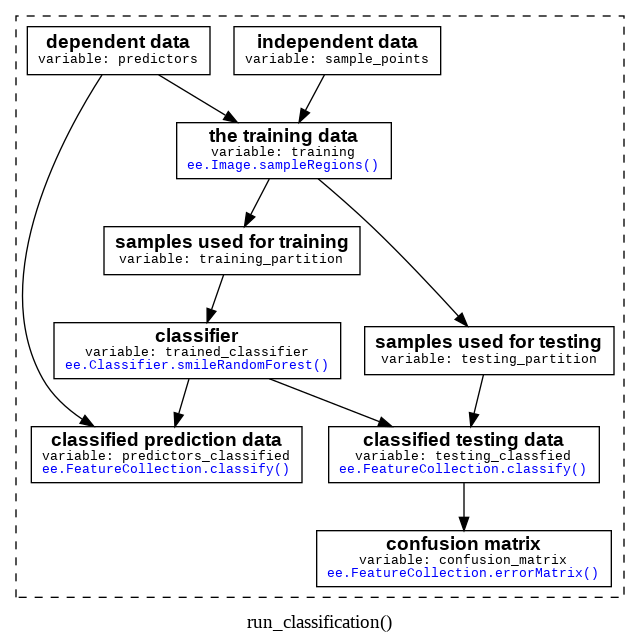

In [ ]:
#@title Classification Flowchart
def create_classification_cluster():
  cluster = pydot.Cluster(label='',
                          labelloc='b',
                          style='dashed')
  cluster.add_node(create_node(obj_name='sample_points',
                              desc='independent data'))
  cluster.add_node(create_node(obj_name='predictors',
                              desc='dependent data'))
  cluster.add_node(create_node(obj_name='training',
                              desc='the training data',
                              method='ee.Image.sampleRegions()'))

  cluster.add_node(create_node(obj_name='training_partition',
                               desc='samples used for training'))
  cluster.add_node(create_node(obj_name='testing_partition',
                               desc='samples used for testing'))
  cluster.add_node(create_node(obj_name='trained_classifier',
                               desc='classifier',
                               method='ee.Classifier.smileRandomForest()'))
  cluster.add_node(create_node(obj_name='predictors_classified',
                               desc='classified prediction data',
                               method='ee.FeatureCollection.classify()'))
  cluster.add_node(create_node(obj_name='testing_classfied',
                               desc='classified testing data',
                               method='ee.FeatureCollection.classify()'))
  cluster.add_node(create_node(obj_name='confusion_matrix',
                               desc='confusion matrix',
                               method='ee.FeatureCollection.errorMatrix()'))

  cluster.add_edge(pydot.Edge('sample_points', 'training'))
  cluster.add_edge(pydot.Edge('predictors', 'training'))
  cluster.add_edge(pydot.Edge('training', 'training_partition'))
  cluster.add_edge(pydot.Edge('training', 'testing_partition'))
  cluster.add_edge(pydot.Edge('training_partition', 'trained_classifier'))
  cluster.add_edge(pydot.Edge('predictors', 'predictors_classified'))
  cluster.add_edge(pydot.Edge('trained_classifier', 'predictors_classified'))
  cluster.add_edge(pydot.Edge('testing_partition', 'testing_classfied'))
  cluster.add_edge(pydot.Edge('trained_classifier', 'testing_classfied'))
  cluster.add_edge(pydot.Edge('testing_classfied', 'confusion_matrix'))

  return cluster

cluster_classification = create_classification_cluster()

# Display the classification cluster.
base_graph = pydot.Dot(label='run_classification()',
                       graph_type='digraph',
                       bgcolor='white')
base_graph.add_subgraph(cluster_classification)
view_pydot(base_graph)

In [ ]:
def run_classification(predictors, sample_points):

  ######################################################
  # Train a classifier.

  ######################################################
  # Sample the predictor data layer to generate training data.
  training = predictors.sampleRegions(
    collection=sample_points,
    properties=[class_property, class_desc],
    scale=30,
    tileScale=4,
    # geometries=True  # Uncomment this if you want to display locations.
  )

  # We want to reserve some of the data for testing, to avoid overfitting the model.
  split = 0.7  # Roughly 70% training, 30% testing.
  # Add a column of random uniforms to the sample dataset
  with_random = training.randomColumn('random')
  training_partition = with_random.filter(ee.Filter.lt('random', split))
  testing_partition = with_random.filter(ee.Filter.gte('random', split))

  # print(f'training_partition = {training_partition.getInfo()}')
  # print(f'testing_partition = {testing_partition.getInfo()}')

  # Trained with 70% of our data.
  trained_classifier = ee.Classifier.smileRandomForest(5).train(
    features=training_partition,
    classProperty=class_property,
    inputProperties=bands
  )

  # Classify the training FeatureCollection.
  predictors_classified = predictors.classify(trained_classifier,
                                   predicted_class_property)

  ######################################################
  # Accuracy assessment

  # Classify the test FeatureCollection with the trained classifier.
  testing_classfied = testing_partition.classify(trained_classifier,
                                    predicted_class_property)

  # Print the confusion matrix.
  # print(f'DEBUG testing_classfied = {testing_classfied.getInfo()}')
  # print(f'DEBUG class_property = {class_property.getInfo()}')
  # print(f'DEBUG predicted_class_property = {predicted_class_property.getInfo()}')
  confusion_matrix = testing_classfied.errorMatrix(class_property,
                                      predicted_class_property)
  print(f'Confusion Matrix = {confusion_matrix.getInfo()}')
  print(f'Accuracy (overall) = {confusion_matrix.accuracy().getInfo()}')

We also define names for training and prediction properties that will be used.

In [ ]:
# The name of the property storing the class label.
class_property = 'training_landcover'

# Define name of the property storing the class description.
class_desc = 'training_landcover_desc'

predicted_class_property = 'predicted_landcover'

## Manually drawn training data

In this section we are going to use manually draw training data as inputs for the classifier.

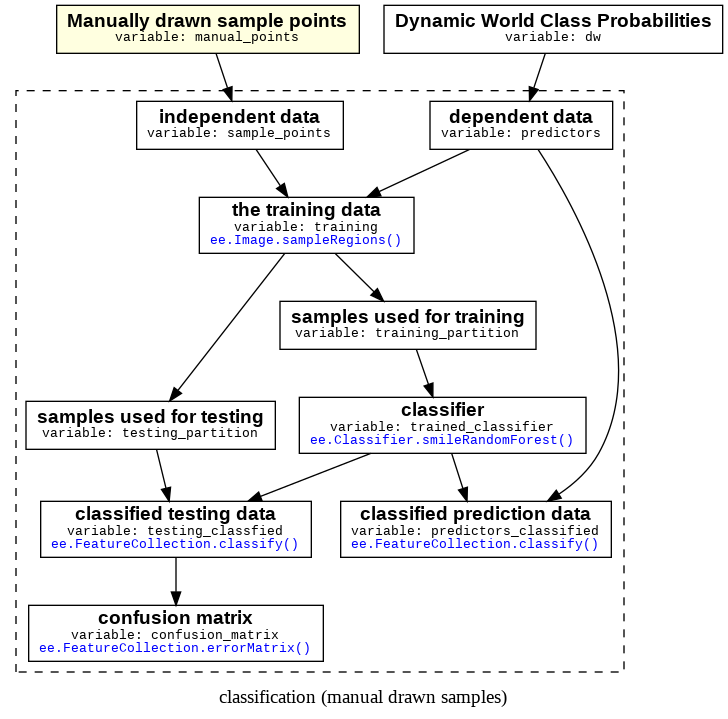

In [ ]:
#@title Classification Flowchart (manually drawn training data)

manual_graph = pydot.Dot(label='classification (manual drawn samples)',
                       graph_type='digraph',
                       bgcolor='white')
manual_graph.add_subgraph(cluster_classification)
manual_graph.add_node(create_node(obj_name='manual_points',
                           desc='Manually drawn sample points',
                           style='filled',
                           fillcolor='lightyellow'))
manual_graph.add_node(create_node(obj_name='dw',
                           desc='Dynamic World Class Probabilities'))
manual_graph.add_edge(pydot.Edge('manual_points', 'sample_points'))
manual_graph.add_edge(pydot.Edge('dw', 'predictors'))
view_pydot(manual_graph)

For our dependent data (`predictors`) we will use the Dynamic World dataset's mean class probabilities from a particular time period.

In [ ]:
start_date = '2020-04-01'
end_date = '2020-10-01'

predictors = dw_base.filterDate(start_date, end_date).mean()
bands = predictors.bandNames().remove('label')
predictors = predictors.select(bands)

In [ ]:
pprint(predictors.getInfo())

{'bands': [{'crs': 'EPSG:4326',
            'crs_transform': [1, 0, 0, 0, 1, 0],
            'data_type': {'precision': 'double', 'type': 'PixelType'},
            'id': 'water'},
           {'crs': 'EPSG:4326',
            'crs_transform': [1, 0, 0, 0, 1, 0],
            'data_type': {'precision': 'double', 'type': 'PixelType'},
            'id': 'trees'},
           {'crs': 'EPSG:4326',
            'crs_transform': [1, 0, 0, 0, 1, 0],
            'data_type': {'precision': 'double', 'type': 'PixelType'},
            'id': 'grass'},
           {'crs': 'EPSG:4326',
            'crs_transform': [1, 0, 0, 0, 1, 0],
            'data_type': {'precision': 'double', 'type': 'PixelType'},
            'id': 'flooded_vegetation'},
           {'crs': 'EPSG:4326',
            'crs_transform': [1, 0, 0, 0, 1, 0],
            'data_type': {'precision': 'double', 'type': 'PixelType'},
            'id': 'crops'},
           {'crs': 'EPSG:4326',
            'crs_transform': [1, 0, 0, 0, 1, 0],
      

In [ ]:
map_init_params_malaysia = {
    'center': (2.86, 101.34),
    'zoom': 12,
    'layers':(satellite_basemap, )
}

map7 = Map(**map_init_params_malaysia)
map7.addLayer(predictors)
map7

Map(center=[2.86, 101.34], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_o…

For our independent data, we will use visual interpretation of satellite imagery and hand-draw regions on a map. To facilitate this, we first create synchronized interactive maps that have drawing tools for defining training data.

In [ ]:
satellite_basemap = ipyleaflet.basemap_to_tiles(
    ipyleaflet.basemaps.Esri.WorldImagery)

def synchronize_maps(map_list):
  """Synchromizes the center and zoom of a list of map objects."""
  for m in map_list[1:]:
    widgets.link((map_list[0], 'center'), (m, 'center'))
    widgets.link((map_list[0], 'zoom'), (m, 'zoom'))

def create_drawable_map(name, color):
  # TODO: generalize map init params
  m = Map(**map_init_params_malaysia)

  draw_control = ipyleaflet.DrawControl()
  draw_control.polyline =  {}
  draw_control.polygon = {
      "shapeOptions": {
          "fillColor": color,
          "color": "#6be5c3",
          "fillOpacity": 1.0
      },
      "drawError": {
          "color": "#dd253b",
          "message": "Oups!"
      },
      "allowIntersection": False
  }
  draw_control.circlemarker = {}
  m.add_control(draw_control)
  return {'map': m,
          'draw control': draw_control}

training_classes = [
  {'name': 'Oil palm', 'color': '#FF0000'},
  {'name': 'Other vegetation', 'color': '#00FF00'},
  {'name': 'Non-vegetation', 'color': '#0000FF'},
]

# Create maps, draw_control objects, and labels.
label_list = []
map_list = []
draw_control_list = []
for count, tc in enumerate(training_classes):
  label_list.append(widgets.HTML(f'<h1>Class {count} ({tc["name"]})</H1>'))
  map_artifacts = create_drawable_map(**tc)
  map_list.append(map_artifacts['map'])
  draw_control_list.append(map_artifacts['draw control'])
synchronize_maps(map_list)

flat_list = [item for sublist in zip(label_list, map_list) for item in sublist]
widgets.GridBox(children=flat_list,
        layout=widgets.Layout(
            width='100%',
            grid_template_rows='auto auto',
            grid_template_columns='30% 70%',
        )
)

GridBox(children=(HTML(value='<h1>Class 0 (Oil palm)</H1>'), Map(center=[2.86, 101.34], controls=(ZoomControl(…

In [ ]:
# Extract a list of polygon coordinates.
poly_coords = []
for i, name in enumerate(training_classes):
  poly_coords.append(
      [poly['geometry']['coordinates']
       for poly in draw_control_list[i].data]
  )
print(poly_coords)

[[[[[101.321699, 2.87925], [101.299654, 2.864379], [101.323005, 2.847774], [101.321699, 2.87925]]]], [[[[101.577279, 2.724443], [101.567574, 2.732669], [101.561317, 2.724378], [101.577279, 2.724443]]]], [[[[101.573628, 2.811228], [101.577988, 2.802662], [101.584407, 2.805474], [101.582822, 2.811246], [101.578365, 2.813179], [101.573628, 2.811228]]]]]


In [ ]:
# Extract points for each class.
extracted_points = []
for i, aoi in enumerate(poly_coords):
  extracted_points.append(
      ee.Image(i).rename(class_property).sample(
        region=ee.Geometry.Polygon(aoi[0]),
        scale=10,
        numPixels=100,
        dropNulls=True,
        geometries=True,
      )
  )
sample_points = ee.FeatureCollection(extracted_points).flatten()

In [ ]:
run_classification(predictors, sample_points)

Confusion Matrix = [[24, 2, 1], [0, 27, 0], [0, 0, 19]]
Accuracy (overall) = 0.958904109589041


---

### Your turn

Take a few minutes to customize the previous section. Here a few suggestions:

1.   Update the location of interest by replacing the `map_init_params_malaysia` parameters.
2.   Change the number of classes used for classification, by modifying the `training_classes` variable.
3.   Change the number of points that are extracted for each class, to see if it significantly changes the accuracy (`numPixels=100`)

---

## Using LUCAS training data

In this section we are going to use training data obtained from the European Union's [Land Use/Cover Area frame Survey (LUCAS)](https://developers.google.com/earth-engine/datasets/catalog/JRC_LUCAS_HARMO_THLOC_V1) dataset as inputs for the classifier.

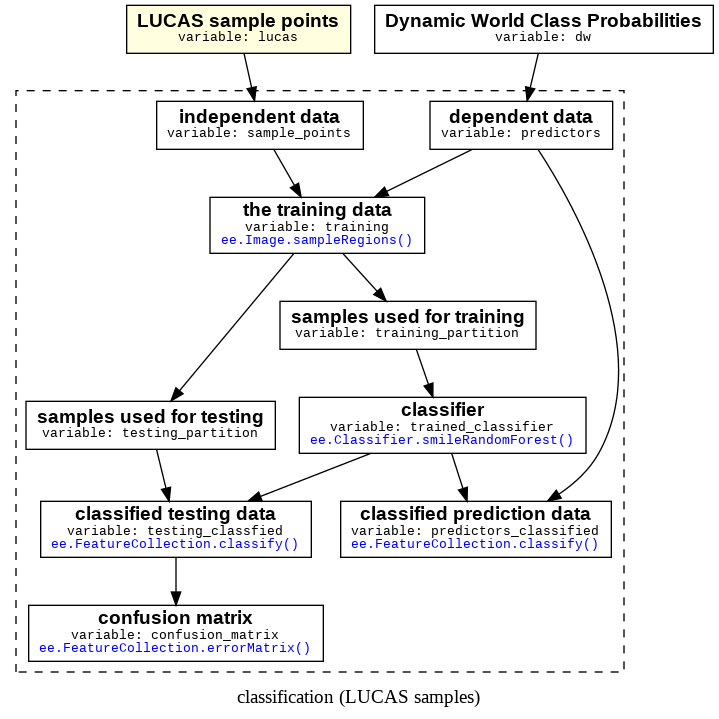

In [ ]:
#@title Classification Flowchart (LUCAS training data)
lucas_graph = pydot.Dot(label='classification (LUCAS samples)',
                       graph_type='digraph',
                       bgcolor='white')
lucas_graph.add_subgraph(cluster_classification)
lucas_graph.add_node(create_node(obj_name='lucas',
                           desc='LUCAS sample points',
                           style='filled',
                           fillcolor='lightyellow'))
lucas_graph.add_node(create_node(obj_name='dw',
                           desc='Dynamic World Class Probabilities'))
lucas_graph.add_edge(pydot.Edge('lucas', 'sample_points'))
lucas_graph.add_edge(pydot.Edge('dw', 'predictors'))
view_pydot(lucas_graph)

In [ ]:
lucas = ee.FeatureCollection("JRC/LUCAS_HARMO/THLOC/V1")

In [ ]:
start_date = '2020-04-01'
end_date = '2020-10-01'

In [ ]:
lucas_filtered = (lucas
    .filter(ee.Filter.eq('year', 2018))
    .filter(ee.Filter.eq('letter_group', 'B')) # land cover filter
    .filter(ee.Filter.eq('lu1', 'U111'))       # land use filter
)

Each LUCAS sample point contains a lot of attributes/metadata, as can be seen from the following sample:

In [ ]:
sample = lucas_filtered.first()
sample.getInfo()

{'type': 'Feature',
 'geometry': {'type': 'Point',
  'coordinates': [-7.898597437313982, 42.22526122515939]},
 'id': '00000000000000001959',
 'properties': {'bio_sample': False,
  'bulk0_10_sample': False,
  'bulk10_20_sample': False,
  'bulk20_30_sample': False,
  'car_ew': 'West',
  'car_latitude': 42.225084,
  'car_longitude': 7.898871898651123,
  'cprn_cando': True,
  'cprn_impervious_perc': 0,
  'cprn_lc': 'B1',
  'cprn_lc1e_brdth': 70,
  'cprn_lc1e_next': 'C1',
  'cprn_lc1n': 10,
  'cprn_lc1n_brdth': 60,
  'cprn_lc1n_next': 'A2',
  'cprn_lc1s_brdth': 80,
  'cprn_lc1s_next': 'E2',
  'cprn_lc1w_brdth': 80,
  'cprn_lc1w_next': 'A2',
  'cprn_lc_label': 'Cereals',
  'cprn_urban': False,
  'cprnc_lc1e': 30,
  'cprnc_lc1s': 30,
  'cprnc_lc1w': 10,
  'crop_residues': False,
  'erosion_cando': True,
  'eunis_complex': '',
  'ex_ante': False,
  'feature_width': '',
  'file_path_gisco_east': 'https://gisco-services.ec.europa.eu/lucas/photos/2018/ES/285/423/28542300E.jpg',
  'file_path_gisco

In [ ]:
def print_lucas_land_cover_class_histogram(lucas_samples):
  def temp_func(f):
    combo = (ee.String('[')
               .cat(ee.String(f.get('lc1')))
               .cat('] ')
               .cat(ee.String(f.get('lc1_label'))))
    return f.set('lc1_combo', combo)

  print('available LUCAS land cover classes histogram:')
  pprint(lucas_samples.map(temp_func)
                      .aggregate_histogram('lc1_combo').getInfo())

#print_lucas_land_cover_class_histogram(lucas_filtered)

In [ ]:
def extract_lucas_sample_points(
    class1,
    class2,
    maxSamplesPerClass):

  ######################################################
  # Define the sample locations

  samples = lucas_filtered.select(
      ['lc1', 'lc1_label', 'letter_group', 'lu1', 'lu1_label'])

  # Select class samples & add properties for classification.
  filter_a = ee.Filter.eq('lc1_label', class1)
  class_a = samples.filter(filter_a)
  class_a = class_a.map(
      lambda f: f.set(class_property, 0).set(class_desc, class1)
  ).limit(maxSamplesPerClass)

  filter_b = ee.Filter.eq('lc1_label', class2)
  class_b = samples.filter(filter_b)
  class_b = class_b.map(
    lambda f: f.set(class_property, 1).set(class_desc, class2)
  ).limit(maxSamplesPerClass);

  class_c = samples.filter(ee.Filter.Or(filter_a, filter_b).Not())
  class_c = class_c.map(
    lambda f: f.set(class_property, 2).set(class_desc, 'other agriculture')
  ).limit(maxSamplesPerClass)

  sample_points = class_a.merge(class_b).merge(class_c);

  return sample_points

In [ ]:
sample_points = extract_lucas_sample_points('Potatoes', 'Olive groves', 100)
# sample_points.getInfo()

print(f'sample class histogram: = '
      f'{sample_points.aggregate_histogram(class_desc).getInfo()}')

sample class histogram: = {'Olive groves': 100, 'Potatoes': 100, 'other agriculture': 100}


In [ ]:
run_classification(predictors, sample_points)

Confusion Matrix = [[20, 2, 3], [11, 21, 1], [4, 0, 21]]
Accuracy (overall) = 0.7469879518072289


---

### Your turn

Take a few minutes to customize the previous section. Here a few suggestions:

1.   Change the LUCAS classes that you try to train on by altering the class names passed to `extract_lucas_sample_points()`. What kind of accuracy do you get when trying to classify similar types of agriculture?
3.   Change the number of points that are extracted for each class, to see if it significantly changes the accuracy (`maxSamplesPerClass`)

---

<a name="resources"></a>
# Additional Resources

To learn more about Dynamic World, here some resources:

* Dynamic World website: [dynamicworld.app](dynamicworld.app)
* [Geo for Good 2022 session](https://earthoutreachonair.withgoogle.com/events/geoforgood22?talk=day3-tracktwo-talk1) (2 hours of video recording, featuring hands-on exploration in the Code Editor)
* Earth Engine Documentation tutorial: [Introduction to Dynamic World](https://developers.google.com/earth-engine/tutorials/community/introduction-to-dynamic-world-pt-1)